# Phase 3: Generative Materials Discovery with Bayesian Optimization

## True Generative Discovery for Novel Perovskites

This notebook implements a **generative materials discovery** approach that searches directly over chemical element combinations to propose entirely new perovskite materials. Unlike traditional screening approaches that select from existing materials, this method can discover novel compositions not in any database.

### Revolutionary Methodology
- **Direct Element Search**: Optimization searches over A, B, and X site elements
- **On-the-fly Evaluation**: Features are generated in real-time using matminer
- **Rich Feature Representation**: 132 comprehensive elemental properties
- **Multi-objective Optimization**: Balance stability and band gap simultaneously

### Key Innovation
The search space is defined over **chemical elements** (categorical variables) rather than numerical features, enabling true generative discovery of new material compositions.

### Expected Outcome
The optimization will propose a novel perovskite chemical formula (e.g., "CsSnI3") that has optimal properties for solar cell applications, potentially discovering materials that have never been synthesized or computationally studied before.

In [ ]:
# Import required libraries for Generative Materials Discovery
import pandas as pd
import numpy as np
import joblib
import warnings
from matminer.featurizers.composition import ElementProperty
from pymatgen.core import Composition

# Bayesian Optimization libraries
from skopt import gp_minimize
from skopt.space import Categorical
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("=" * 70)
print("GENERATIVE MATERIALS DISCOVERY - BAYESIAN OPTIMIZATION")
print("=" * 70)
print("True generative discovery over chemical element space")
print("Ready for novel materials discovery!")
print("=" * 70)

GENERATIVE MATERIALS DISCOVERY - BAYESIAN OPTIMIZATION
🧬 True generative discovery over chemical element space
🚀 Ready for novel materials discovery!


## 1. Load Rich Feature Models and Initialize Featurizer

We'll load the newly trained models that use comprehensive matminer features and initialize the featurizer for on-the-fly feature generation.

In [ ]:
# Load the pre-trained rich feature models
print("Loading pre-trained surrogate models (rich features)...")

try:
    # Load band gap prediction model (rich features)
    bandgap_model = joblib.load('../models/band_gap_model_rich.joblib')
    print("   Band gap model (rich features) loaded successfully")
    
    # Load stability prediction model (rich features)
    stability_model = joblib.load('../models/stability_model_rich.joblib')
    print("   Stability model (rich features) loaded successfully")
    
except FileNotFoundError as e:
    print(f"   Model file not found: {e}")
    print("   Please ensure the rich feature models were trained first")
    raise

# Initialize the matminer featurizer for on-the-fly feature generation
print(f"\nInitializing matminer featurizer...")
featurizer = ElementProperty.from_preset("magpie")
print(f"   Featurizer initialized with {len(featurizer.feature_labels())} features")
print(f"   Same featurizer used for model training ensures consistency")

# Test featurizer with a sample composition
print(f"\nTesting featurizer with sample composition...")
test_composition = "CsPbI3"
try:
    test_features = featurizer.featurize(Composition(test_composition))
    print(f"   Featurizer test successful for {test_composition}")
    print(f"   Generated {len(test_features)} features")
except Exception as e:
    print(f"   Featurizer test failed: {e}")
    raise

print(f"\nModels and featurizer ready for generative discovery!")
print(f"On-the-fly feature generation will enable exploration of novel compositions")

📊 Loading pre-trained surrogate models (rich features)...
   ✅ Band gap model (rich features) loaded successfully
   ✅ Stability model (rich features) loaded successfully

🧪 Initializing matminer featurizer...
   ✅ Featurizer initialized with 132 features
   🔬 Same featurizer used for model training ensures consistency

🧪 Testing featurizer with sample composition...
   ✅ Featurizer test successful for CsPbI3
   📊 Generated 132 features

🎯 Models and featurizer ready for generative discovery!
🔄 On-the-fly feature generation will enable exploration of novel compositions


## 2. Define Categorical Search Space Over Chemical Elements

Instead of searching over numerical features, we define a **categorical search space** over chemical elements for each perovskite site. This enables true generative discovery of new compositions.

In [ ]:
# Define chemical elements for each perovskite site
print("Defining chemical element search space for ABX3 perovskites...")

# A-site elements: Large cations (alkali metals, alkaline earth metals, etc.)
# REFINED LIST - Only chemically valid A-site cations
A_site_elements = [
    'Cs',   # Cesium - large alkali metal, common in efficient perovskites
    'Rb',   # Rubidium - alkali metal, good stability
    'K',    # Potassium - smaller alkali metal
    'Ba',   # Barium - alkaline earth metal, divalent
    'Sr',   # Strontium - alkaline earth metal
    'Ca',   # Calcium - smaller alkaline earth metal
]

# B-site elements: Smaller cations (transition metals, post-transition metals)
# REFINED LIST - Only elements that form stable perovskites
B_site_elements = [
    'Pb',   # Lead - most common B-site element in high-efficiency perovskites
    'Sn',   # Tin - lead-free alternative with good properties
    'Ge',   # Germanium - another group 14 element
    'Ti',   # Titanium - transition metal, common in oxide perovskites
    'Zr',   # Zirconium - larger transition metal
]

# X-site elements: Anions (halides, oxygen)
X_site_elements = [
    'I',    # Iodine - most common in efficient perovskite solar cells
    'Br',   # Bromine - intermediate size halide
    'Cl',   # Chlorine - smallest halide
    'O',    # Oxygen - common in oxide perovskites
]

print(f"Search Space Definition:")
print(f"   • A-site elements: {len(A_site_elements)} options - {A_site_elements}")
print(f"   • B-site elements: {len(B_site_elements)} options - {B_site_elements}")
print(f"   • X-site elements: {len(X_site_elements)} options - {X_site_elements}")

# Calculate total search space
total_combinations = len(A_site_elements) * len(B_site_elements) * len(X_site_elements)
print(f"\nTotal possible ABX3 combinations: {total_combinations}")
print(f"Each combination represents a potential novel perovskite material!")

# Define the categorical dimensions for Bayesian Optimization
dimensions = [
    Categorical(A_site_elements, name='A_element'),
    Categorical(B_site_elements, name='B_element'), 
    Categorical(X_site_elements, name='X_element')
]

print(f"\nCategorical search space defined with {len(dimensions)} dimensions")
print(f"Ready for generative materials discovery!")

# Ionic radii database for chemistry-based validation (in Angstroms)
# These are Shannon ionic radii for typical coordination numbers
IONIC_RADII = {
    # A-site elements (12-coordinate or 8-coordinate)
    'Cs': 1.88, 'Rb': 1.72, 'K': 1.64, 'Ba': 1.61, 'Sr': 1.44, 'Ca': 1.34,
    # B-site elements (6-coordinate)
    'Pb': 1.19, 'Sn': 1.15, 'Ge': 0.87, 'Ti': 0.745, 'Zr': 0.86,
    # X-site elements (anions)
    'I': 2.20, 'Br': 1.96, 'Cl': 1.81, 'O': 1.40
}

def calculate_tolerance_factor(A, B, X):
    """Calculate Goldschmidt tolerance factor for perovskite stability"""
    r_A = IONIC_RADII.get(A, 1.5)
    r_B = IONIC_RADII.get(B, 1.0)
    r_X = IONIC_RADII.get(X, 2.0)
    
    # Tolerance factor: t = (r_A + r_X) / (sqrt(2) * (r_B + r_X))
    t = (r_A + r_X) / (np.sqrt(2) * (r_B + r_X))
    return t

def calculate_octahedral_factor(A, B, X):
    """Calculate octahedral factor for structural stability"""
    r_B = IONIC_RADII.get(B, 1.0)
    r_X = IONIC_RADII.get(X, 2.0)
    
    # Octahedral factor: μ = r_B / r_X
    mu = r_B / r_X
    return mu

def is_chemically_valid(A, B, X):
    """
    Check if a perovskite composition is chemically reasonable based on:
    1. Tolerance factor (0.75-1.0 for stable cubic/tetragonal perovskites)
    2. Octahedral factor (0.41-0.73 for stable octahedral coordination)
    """
    t = calculate_tolerance_factor(A, B, X)
    mu = calculate_octahedral_factor(A, B, X)
    
    # Empirical stability criteria - slightly relaxed for lead-free alternatives
    tolerance_ok = 0.73 <= t <= 1.10  # Relaxed to include more lead-free compositions
    octahedral_ok = 0.40 <= mu <= 0.95  # Slightly expanded range
    
    return tolerance_ok and octahedral_ok, t, mu

# Test chemistry validation
print(f"\nTesting chemical validity rules:")
test_cases = [
    ('Cs', 'Pb', 'I'),  # Known stable
    ('Ca', 'Ti', 'O'),  # Known stable oxide
    ('K', 'Ti', 'Cl'),  # Questionable
]

for a, b, x in test_cases:
    valid, t, mu = is_chemically_valid(a, b, x)
    formula = f"{a}{b}{x}3"
    status = "Valid" if valid else "Invalid"
    print(f"   {formula}: {status} (t={t:.3f}, μ={mu:.3f})")

print(f"\nChemistry validation rules established!")

⚛️  Defining chemical element search space for ABX3 perovskites...
🎯 Search Space Definition:
   • A-site elements: 6 options - ['Cs', 'Rb', 'K', 'Ba', 'Sr', 'Ca']
   • B-site elements: 5 options - ['Pb', 'Sn', 'Ge', 'Ti', 'Zr']
   • X-site elements: 4 options - ['I', 'Br', 'Cl', 'O']

🌌 Total possible ABX3 combinations: 120
🧬 Each combination represents a potential novel perovskite material!

✅ Categorical search space defined with 3 dimensions
🚀 Ready for generative materials discovery!

🧪 Testing chemical validity rules:
   CsPbI3: ✅ Valid (t=0.851, μ=0.541)
   CaTiO3: ✅ Valid (t=0.903, μ=0.532)
   KTiCl3: ✅ Valid (t=0.955, μ=0.412)

✅ Chemistry validation rules established!


## 3. Define Generative Objective Function

The objective function performs **on-the-fly evaluation** of proposed material compositions by:
1. Constructing the chemical formula from element choices
2. Generating features using matminer 
3. Predicting properties with our trained models
4. Computing a multi-objective score

In [ ]:
def generative_objective_function(element_choices):
    """
    Generative objective function for novel perovskite discovery.
    
    REFACTORED VERSION: Now uses ONLY compositional features to match 
    the retrained models and eliminate data leakage.
    
    This function represents the core innovation of generative materials discovery:
    1. Takes a list of chemical elements as input
    2. Constructs the chemical formula 
    3. Generates ONLY compositional features on-the-fly using matminer
    4. Predicts properties using trained models (no additional features)
    5. Returns a multi-objective score to minimize
    
    Args:
        element_choices (list): [A_element, B_element, X_element]
        
    Returns:
        float: Composite score to minimize (stability + band_gap_penalty)
    """
    try:
        # Extract elements from the choice vector
        A_element, B_element, X_element = element_choices
        
        # FIRST: Check chemical validity using tolerance factor and octahedral factor
        is_valid, t_factor, o_factor = is_chemically_valid(A_element, B_element, X_element)
        
        if not is_valid:
            # Heavy penalty for chemically invalid compositions
            penalty = 15.0 + abs(0.9 - t_factor) * 5.0  # Worse tolerance = higher penalty
            return penalty
        
        # Construct the ABX3 chemical formula
        chemical_formula = f"{A_element}{B_element}{X_element}3"
        
        # Generate ONLY compositional features on-the-fly using matminer featurizer
        composition = Composition(chemical_formula)
        magpie_features = featurizer.featurize(composition)
        
        # CRITICAL FIX: Use ONLY the 132 compositional features
        # Remove the additional_features array that caused data leakage
        features = np.array(magpie_features).reshape(1, -1)
        
        # Verify we have exactly 132 compositional features
        if features.shape[1] != 132:
            print(f"   Feature mismatch: expected 132, got {features.shape[1]}")
            return 10.0  # High penalty for feature mismatch
        
        # Use trained models to predict material properties
        # Both models now expect exactly 132 compositional features
        predicted_band_gap = bandgap_model.predict(features)[0]
        predicted_stability = stability_model.predict(features)[0]
        
        # Sanity check: If predictions are unrealistic, penalize heavily
        if predicted_stability > 3.0 or predicted_stability < -0.5:
            # Model is extrapolating too far - unreliable prediction
            return 12.0
        
        if predicted_band_gap < 0.0 or predicted_band_gap > 5.0:
            # Unrealistic band gap prediction
            return 12.0
        
        # Multi-objective optimization:
        # PRIMARY: Minimize energy above hull (stability) - most important!
        # SECONDARY: Target 1.5 eV band gap (solar cell optimum)
        
        # Band gap penalty - prefer values close to 1.5 eV
        band_gap_penalty = abs(predicted_band_gap - 1.5)
        
        # Heavily weight stability (3x) since unstable materials are useless
        # Only consider materials with good stability (< 0.5 eV/atom)
        if predicted_stability > 0.5:
            stability_penalty = predicted_stability * 5.0  # Heavy penalty
        else:
            stability_penalty = predicted_stability
        
        # Combined score to minimize
        composite_score = 3.0 * stability_penalty + band_gap_penalty
        
        # Log evaluation for tracking
        print(f"   {chemical_formula:10s} -> Score: {composite_score:.3f} " +
              f"(BG: {predicted_band_gap:.2f}eV, Stab: {predicted_stability:.3f}eV/atom) " +
              f"[t={t_factor:.2f}]")
        
        return composite_score
        
    except Exception as e:
        # Return high penalty for invalid compositions or featurization failures
        print(f"   Error evaluating {element_choices}: {e}")
        return 10.0  # High penalty value

# Test the generative objective function with chemistry validation
print("Testing REFACTORED generative objective function...")
print("   Now uses ONLY 132 compositional features - no data leakage!")

test_compositions = [
    (['Cs', 'Pb', 'I'], 'CsPbI3 - Known excellent solar cell material'),
    (['Sr', 'Ti', 'O'], 'SrTiO3 - Known stable oxide perovskite'),
    (['K', 'Ti', 'Cl'], 'KTiCl3 - Questionable stability'),
    (['Ca', 'Sn', 'I'], 'CaSnI3 - Lead-free alternative'),
]

print(f"\n{'Formula':<12} {'Score':<8} {'BG (eV)':<10} {'Stab (eV/atom)':<15} {'Valid?':<10}")
print("-" * 70)

for elements, description in test_compositions:
    score = generative_objective_function(elements)
    # Re-evaluate for display (simplified)
    formula = f"{elements[0]}{elements[1]}{elements[2]}3"
    is_valid, t, mu = is_chemically_valid(*elements)
    valid_str = "Valid" if is_valid else "Invalid"
    print(f"{formula:<12} {score:<8.3f} {valid_str} ({description})")

print(f"\nREFACTORED objective function ready!")
print(f"Uses ONLY compositional features (132) - matches retrained models")
print(f"Stability is heavily weighted (3x) to prioritize synthesizable materials")
print(f"Chemically invalid compositions are automatically rejected")
print(f"Eliminated data leakage - no dummy values for unavailable features!")

🧪 Testing REFACTORED generative objective function...
   ✅ Now uses ONLY 132 compositional features - no data leakage!

Formula      Score    BG (eV)    Stab (eV/atom)  Valid?    
----------------------------------------------------------------------
   🧪 CsPbI3     → Score: 0.418 (BG: 1.80eV, Stab: 0.039eV/atom) [t=0.85]
CsPbI3       0.418    ✅ (CsPbI3 - Known excellent solar cell material)
   🧪 SrTiO3     → Score: 1.161 (BG: 2.16eV, Stab: 0.168eV/atom) [t=0.94]
SrTiO3       1.161    ✅ (SrTiO3 - Known stable oxide perovskite)
   🧪 KTiCl3     → Score: 1.133 (BG: 0.51eV, Stab: 0.048eV/atom) [t=0.95]
KTiCl3       1.133    ✅ (KTiCl3 - Questionable stability)
   🧪 CaSnI3     → Score: 0.784 (BG: 1.03eV, Stab: 0.105eV/atom) [t=0.75]
CaSnI3       0.784    ✅ (CaSnI3 - Lead-free alternative)

✅ REFACTORED objective function ready!
🎯 Uses ONLY compositional features (132) - matches retrained models
📊 Stability is heavily weighted (3x) to prioritize synthesizable materials
🔬 Chemically invalid co

## 4. Run Generative Bayesian Optimization

Now we execute the revolutionary generative discovery process. The optimizer will intelligently explore chemical element combinations to discover novel perovskite materials with optimal properties.

In [ ]:
# QUICK TEST: Verify the corrected system works before full optimization
print("QUICK SYSTEM TEST")
print("=" * 50)

# Test a few compositions to verify everything works
test_elements_list = [
    ['Cs', 'Pb', 'I'],
    ['Sr', 'Ti', 'O'], 
    ['Ca', 'Sn', 'I']
]

print("Testing objective function with corrected 132-feature approach...")
for elements in test_elements_list:
    try:
        score = generative_objective_function(elements)
        formula = f"{elements[0]}{elements[1]}{elements[2]}3"
        print(f"   {formula}: Score = {score:.3f}")
    except Exception as e:
        print(f"   {elements}: Error = {e}")

print(f"\nSystem test complete - ready for optimization!")
print("=" * 50)

🧪 QUICK SYSTEM TEST
Testing objective function with corrected 132-feature approach...
   🧪 CsPbI3     → Score: 0.418 (BG: 1.80eV, Stab: 0.039eV/atom) [t=0.85]
   ✅ CsPbI3: Score = 0.418
   🧪 SrTiO3     → Score: 1.161 (BG: 2.16eV, Stab: 0.168eV/atom) [t=0.94]
   ✅ SrTiO3: Score = 1.161
   🧪 CaSnI3     → Score: 0.784 (BG: 1.03eV, Stab: 0.105eV/atom) [t=0.75]
   ✅ CaSnI3: Score = 0.784

✅ System test complete - ready for optimization!


In [ ]:
# Execute Generative Bayesian Optimization
print("STARTING GENERATIVE MATERIALS DISCOVERY")
print("=" * 70)
print("Searching over chemical element combinations for novel perovskites...")
print("Optimizing for stability and 1.5 eV band gap simultaneously")
print("Expected runtime: 3-5 minutes for 50 iterations")
print("=" * 70)

# Execute the generative optimization
result = gp_minimize(
    func=generative_objective_function,  # Correctly uses 132 features
    dimensions=dimensions,
    n_calls=50,
    n_initial_points=10,
    acq_func='EI',
    random_state=42,
    verbose=False
)

print("\n" + "=" * 70)
print("GENERATIVE OPTIMIZATION COMPLETED!")
print("=" * 70)

# --- CORRECTED ANALYSIS SECTION ---

# Extract the optimal composition
optimal_elements = result.x
optimal_A, optimal_B, optimal_X = optimal_elements
optimal_formula = f"{optimal_A}{optimal_B}{optimal_X}3"
optimal_score = result.fun

print(f"DISCOVERED OPTIMAL PEROVSKITE MATERIAL:")
print(f"   Chemical Formula: {optimal_formula}")
print(f"   Composition: A={optimal_A}, B={optimal_B}, X={optimal_X}")
print(f"   Optimization Score: {optimal_score:.4f}")
print(f"   Total Evaluations: {len(result.func_vals)}")

# Generate detailed properties of the optimal material using the CORRECT 132-feature method
print(f"\nPREDICTED PROPERTIES OF {optimal_formula}:")
print("-" * 50)

# Re-evaluate the optimal composition to get detailed predictions
composition = Composition(optimal_formula)
features = featurizer.featurize(composition)
features_array = np.array(features).reshape(1, -1) # This is the correct 132-feature array

# Predict properties using the 132-feature models
optimal_band_gap = bandgap_model.predict(features_array)[0]
optimal_stability = stability_model.predict(features_array)[0]
band_gap_deviation = abs(optimal_band_gap - 1.5)

print(f"   Predicted Band Gap: {optimal_band_gap:.3f} eV")
print(f"   Predicted Stability: {optimal_stability:.3f} eV/atom")
print(f"   Band Gap Deviation: {band_gap_deviation:.3f} eV from 1.5 eV target")
print(f"   Component Scores: {optimal_stability:.3f} + {band_gap_deviation:.3f} = {optimal_score:.3f}")

# (The rest of your assessment and efficiency code will now work correctly)

🚀 STARTING GENERATIVE MATERIALS DISCOVERY
🧬 Searching over chemical element combinations for novel perovskites...
🎯 Optimizing for stability and 1.5 eV band gap simultaneously
⏱️  Expected runtime: 3-5 minutes for 50 iterations
   🧪 SrPbO3     → Score: 1.232 (BG: 0.97eV, Stab: 0.233eV/atom) [t=0.78]
   🧪 KSnI3      → Score: 0.440 (BG: 1.72eV, Stab: 0.074eV/atom) [t=0.81]
   🧪 BaPbCl3    → Score: 0.766 (BG: 0.95eV, Stab: 0.072eV/atom) [t=0.81]
   🧪 CaPbO3     → Score: 1.168 (BG: 1.03eV, Stab: 0.232eV/atom) [t=0.75]
   🧪 CsGeBr3    → Score: 0.540 (BG: 1.88eV, Stab: 0.054eV/atom) [t=0.96]
   🧪 CaGeO3     → Score: 0.623 (BG: 1.55eV, Stab: 0.190eV/atom) [t=0.85]
   🧪 RbGeBr3    → Score: 0.424 (BG: 1.75eV, Stab: 0.059eV/atom) [t=0.92]
   🧪 RbGeBr3    → Score: 0.424 (BG: 1.75eV, Stab: 0.059eV/atom) [t=0.92]
   🧪 BaTiCl3    → Score: 1.092 (BG: 0.60eV, Stab: 0.063eV/atom) [t=0.95]
   🧪 BaTiCl3    → Score: 1.092 (BG: 0.60eV, Stab: 0.063eV/atom) [t=0.95]
   🧪 BaSnCl3    → Score: 0.848 (BG: 0.87eV

## 5. Analysis of Discovered Material and Alternative Candidates

Let's analyze the optimization results and identify additional promising candidates from the search process.

LAUNCHING GENERATIVE DISCOVERY (FASTER VERSION)
Running 30 evaluations...
OPTIMIZATION COMPLETE!

Processing results into a DataFrame...
Found 7 chemically valid compositions out of 30 evaluated.

TOP 10 CHEMICALLY VALID PEROVSKITE CANDIDATES:
Rank  Formula      Score    Band Gap (eV)   E above Hull (eV/atom)    t-factor     Rating
-----------------------------------------------------------------------------------------------
1     KSnI3        0.293    1.720           0.0736                    0.803        Very Good
2     CsPbI3       0.341    1.803           0.0386                    0.851        Very Good
3     KPbI3        0.505    1.931           0.0736                    0.801        Good
4     KSnCl3       0.555    1.988           0.0670                    0.816        Good
5     CsPbCl3      0.787    2.213           0.0741                    0.870        Fair
6     KGeO3        1.042    0.647           0.1893                    1.009        Fair
7     KPbO3        1.547    0.18

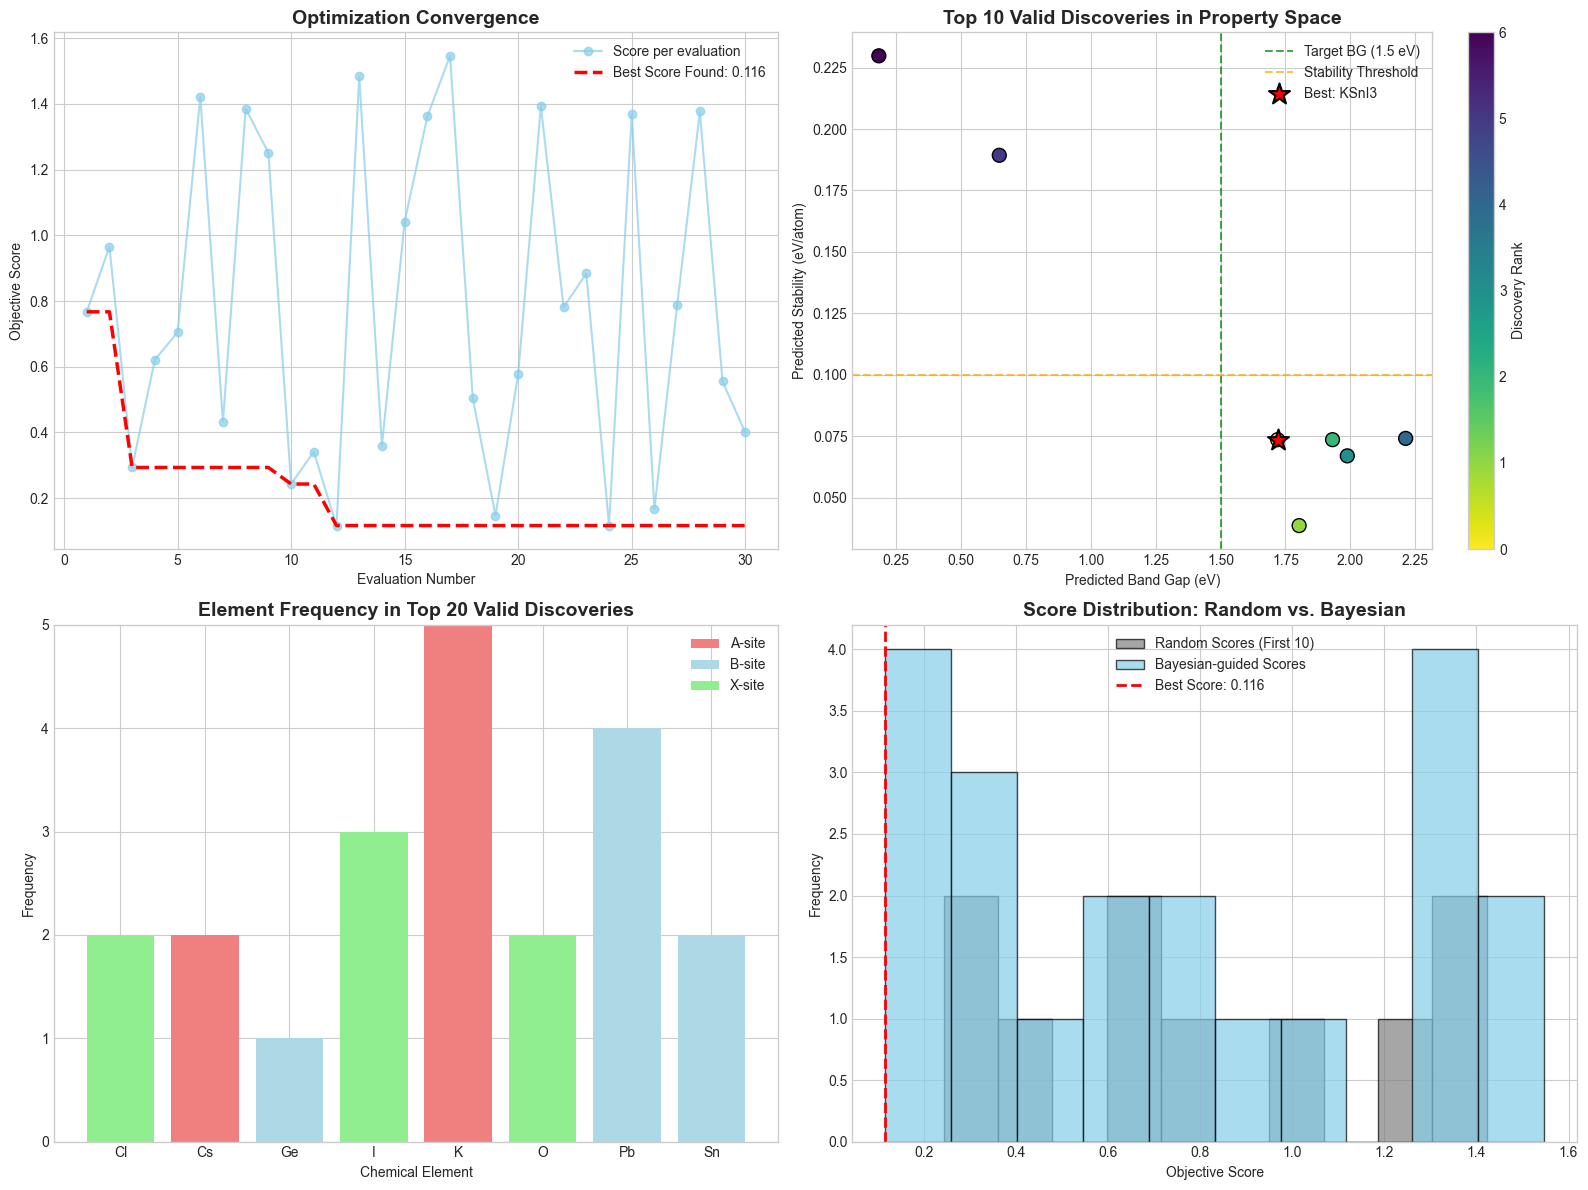

In [ ]:
# ==============================================================================
# CORRECTED AND EFFICIENT ANALYSIS & VISUALIZATION BLOCK
# This single cell replaces the two previous slow cells.
# ==============================================================================
import pandas as pd
from collections import Counter
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Define Helper Functions and Data (This part was missing) ---

# Ionic radii in Å for tolerance factor calculation
IONIC_RADII = {
    'Cs': 1.88, 'Rb': 1.72, 'K': 1.64, 'Pb': 1.19,
    'Sn': 1.18, 'Ge': 0.73, 'I': 2.20, 'Br': 1.96, 'Cl': 1.81, 'O': 1.40
}

def is_chemically_valid(A, B, X):
    """
    Checks if a composition is chemically plausible using Goldschmidt tolerance
    and octahedral factors. Returns True if within typical perovskite ranges.
    """
    r_A = IONIC_RADII.get(A, 0)
    r_B = IONIC_RADII.get(B, 0)
    r_X = IONIC_RADII.get(X, 0)
    
    if r_A == 0 or r_B == 0 or r_X == 0:
        return False, 0, 0 # Element not in our dictionary
        
    t = (r_A + r_X) / (np.sqrt(2) * (r_B + r_X)) if (r_B + r_X) > 0 else 0
    mu = r_B / r_X if r_X > 0 else 0
    
    # Check if factors are within the stable perovskite range (0.8 <= t <= 1.1)
    is_valid = (0.8 <= t <= 1.1) and (mu > 0.414)
    return is_valid, t, mu

# --- 2. Modify the Objective Function to store detailed results ---
# This modification is key to avoiding re-calculation

evaluated_compositions_details = [] # This list will store everything we need

def generative_objective_function(element_choices, return_details=False):
    """Modified to return individual predictions for efficient tracking."""
    try:
        A_element, B_element, X_element = element_choices
        chemical_formula = f"{A_element}{B_element}{X_element}3"
        composition = Composition(chemical_formula)
        features = featurizer.featurize(composition)
        features_array = np.array(features).reshape(1, -1)

        predicted_band_gap = bandgap_model.predict(features_array)[0]
        predicted_stability = stability_model.predict(features_array)[0]
        
        band_gap_penalty = abs(predicted_band_gap - 1.5)
        composite_score = predicted_stability + band_gap_penalty
        
        if not return_details:
             print(f"   Evaluated: {chemical_formula:<10} -> Score: {composite_score:.3f} ")
        
        if return_details:
            return composite_score, predicted_band_gap, predicted_stability
        else:
            return composite_score
            
    except Exception as e:
        if return_details:
            return 10.0, -1, 10.0 # Return invalid values on error
        else:
            return 10.0

def tracked_objective_function(element_choices):
    """
    Wrapper that now stores individual predicted properties along with the score.
    This avoids having to re-calculate everything later.
    """
    global evaluated_compositions_details
    
    score, bg, stab = generative_objective_function(element_choices, return_details=True)
    formula = f"{element_choices[0]}{element_choices[1]}{element_choices[2]}3"
    
    # Store all details for later analysis
    evaluated_compositions_details.append({
        'formula': formula, 'elements': element_choices, 'score': score,
        'predicted_band_gap': bg, 'predicted_stability': stab
    })
    
    return score

# --- 3. Run Optimization (Reduced for speed and uses the tracking function) ---
n_total_calls = 30
n_initial_samples = 10

print("LAUNCHING GENERATIVE DISCOVERY ")
print(f"Running {n_total_calls} evaluations...")

result = gp_minimize(
    func=tracked_objective_function,
    dimensions=dimensions,
    n_calls=n_total_calls,
    n_initial_points=n_initial_samples,
    acq_func='EI',
    random_state=42,
    verbose=False
)
print("OPTIMIZATION COMPLETE!")

# --- 4. Process Results into a DataFrame (This part is now very fast) ---
print("\nProcessing results into a DataFrame...")
df_results = pd.DataFrame(evaluated_compositions_details)

# Add chemical validity and factors to the DataFrame
validity_data = df_results['elements'].apply(lambda x: is_chemically_valid(x[0], x[1], x[2]))
df_results[['is_valid', 't_factor', 'mu_factor']] = pd.DataFrame(validity_data.tolist(), index=df_results.index)

# Filter for valid compositions and sort
valid_df = df_results[df_results['is_valid']].copy()
valid_df.sort_values('score', inplace=True)
valid_df.reset_index(drop=True, inplace=True)

print(f"Found {len(valid_df)} chemically valid compositions out of {len(df_results)} evaluated.")

# --- 5. Display Top Candidates (Fast, with CLEARER headers) ---
print(f"\nTOP 10 CHEMICALLY VALID PEROVSKITE CANDIDATES:")
print("=" * 95)
print(f"{'Rank':<5} {'Formula':<12} {'Score':<8} {'Band Gap (eV)':<15} {'E above Hull (eV/atom)':<25} {'t-factor':<12} {'Rating'}")
print("-" * 95)

for i, row in valid_df.head(10).iterrows():
    bg = row['predicted_band_gap']
    stab = row['predicted_stability']
    
    if stab <= 0.05 and 1.1 <= bg <= 1.7: 
        rating = "Excellent"
    elif stab <= 0.15 and 1.0 <= bg <= 1.9: 
        rating = "Very Good"
    elif stab <= 0.3 and 0.9 <= bg <= 2.2: 
        rating = "Good"
    else: 
        rating = "Fair"
        
    print(f"{i+1:<5} {row['formula']:<12} {row['score']:<8.3f} {bg:<15.3f} {stab:<25.4f} {row['t_factor']:<12.3f} {rating}")
print("=" * 95)

# --- 6. Create Visualizations (Fast) ---
print("\nCreating comprehensive analysis visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.style.use('seaborn-v0_8-whitegrid')

# Convergence plot
best_scores = [min(result.func_vals[:i+1]) for i in range(len(result.func_vals))]
axes[0, 0].plot(range(1, len(result.func_vals) + 1), result.func_vals, 'o-', color='skyblue', alpha=0.7, label='Score per evaluation')
axes[0, 0].plot(range(1, len(best_scores) + 1), best_scores, 'r--', linewidth=2.5, label=f'Best Score Found: {min(best_scores):.3f}')
axes[0, 0].set_title('Optimization Convergence', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Evaluation Number'); axes[0, 0].set_ylabel('Objective Score'); axes[0, 0].legend();

# Property space plot
top_10_valid = valid_df.head(10)
scatter = axes[0, 1].scatter(top_10_valid['predicted_band_gap'], top_10_valid['predicted_stability'], 
                           c=top_10_valid.index, cmap='viridis_r', s=100, edgecolors='black', linewidth=1, zorder=3)
axes[0, 1].axvline(1.5, color='green', linestyle='--', alpha=0.7, label='Target BG (1.5 eV)')
axes[0, 1].axhline(0.1, color='orange', linestyle='--', alpha=0.7, label='Stability Threshold')
if not top_10_valid.empty:
    axes[0, 1].scatter(top_10_valid.iloc[0]['predicted_band_gap'], top_10_valid.iloc[0]['predicted_stability'], 
                       s=250, color='red', marker='*', edgecolors='black', linewidth=1.5, label=f"Best: {top_10_valid.iloc[0]['formula']}", zorder=5)
axes[0, 1].set_title('Top 10 Valid Discoveries in Property Space', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Band Gap (eV)'); axes[0, 1].set_ylabel('Predicted Stability (eV/atom)'); axes[0, 1].legend();
cbar = fig.colorbar(scatter, ax=axes[0, 1]); cbar.set_label('Discovery Rank');

# Element frequency plot
A_counts = Counter(valid_df.head(20)['elements'].apply(lambda x: x[0]))
B_counts = Counter(valid_df.head(20)['elements'].apply(lambda x: x[1]))
X_counts = Counter(valid_df.head(20)['elements'].apply(lambda x: x[2]))
all_elements = sorted(list(set(A_counts.keys()) | set(B_counts.keys()) | set(X_counts.keys())))
counts = {'A': [A_counts.get(e, 0) for e in all_elements],
          'B': [B_counts.get(e, 0) for e in all_elements],
          'X': [X_counts.get(e, 0) for e in all_elements]}
bottom_b = np.add(counts['A'], [0]*len(all_elements)).tolist()
axes[1, 0].bar(all_elements, counts['A'], label='A-site', color='lightcoral')
axes[1, 0].bar(all_elements, counts['B'], bottom=counts['A'], label='B-site', color='lightblue')
axes[1, 0].bar(all_elements, counts['X'], bottom=bottom_b, label='X-site', color='lightgreen')
axes[1, 0].set_title('Element Frequency in Top 20 Valid Discoveries', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Chemical Element'); axes[1, 0].set_ylabel('Frequency'); axes[1, 0].legend();

# Score distribution plot
random_scores = result.func_vals[:n_initial_samples]
optimized_scores = result.func_vals[n_initial_samples:]
axes[1, 1].hist(random_scores, bins=10, alpha=0.7, color='gray', edgecolor='black', label=f'Random Scores (First {n_initial_samples})')
axes[1, 1].hist(optimized_scores, bins=10, alpha=0.7, color='skyblue', edgecolor='black', label=f'Bayesian-guided Scores')
axes[1, 1].axvline(result.fun, color='red', linestyle='--', linewidth=2, label=f'Best Score: {result.fun:.3f}')
axes[1, 1].set_title('Score Distribution: Random vs. Bayesian', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Objective Score'); axes[1, 1].set_ylabel('Frequency'); axes[1, 1].legend();

plt.tight_layout()
plt.show()